# How to create your own Dataset?

More practical would be for example to use your own dataset, not a sample dataset embedded in the PyTorch package. For simplicity, let’s assume that our dataset will be 500 readings of 10 integers, along with their classification into 10 classes, marked with numbers from 0 to 9.

The first step in the process of preparing your own dataset is to define our own class, which inherits from the “abstract” Dataset class. The implementation is simple because such a class requires only two methods to be overwritten: `__getitem__` and `__len__`. Plus of course you should provide the code for the method that initializes the object (`__init__`).

Now let’s look at how you can implement data retrieval for the [Facial Key Point Detection Dataset](https://www.kaggle.com/prashantarorat/facial-key-point-data). After downloading and unpacking the file, we will get the images directory containing 5000 files, cut to the same size, and a json file containing the coordinates of 68 key face points for each of the files. These key points usually identify the eyes, lip line, eyebrows, and the oval of a face.

The dataset was prepared by [Prashant Arora](https://www.kaggle.com/prashantarorat) as a subset of the original, much larger [Flickr-Faces-HQ dataset](https://github.com/NVlabs/ffhq-dataset), created by the NVIDIA team and made available under the [Creative Commons BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

We import the necessary libraries and create the class inheriting from Dataset, in which we implement the three required methods. The `__init__` method sets a variable pointing to the name of the data directory. It should be in the directory from which we run this script. We should unpack the downloaded file to this data directory. The `__len__` method returns the size of the variable with the coordinates of key points, which happens to be also the size of the entire dataset. The `__getitem__` method first gets the name of the file with index i from the variable with coordinates, and then loads the image from the appropriate file located in the images directory.

In [57]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import json # we need to import json file with key points coordinates
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [97]:
class FacialDetectionDataset(Dataset):
    KEY_POINTS_FILE = 'all_data.json'
    IMAGES_DIR = 'images'

    def __init__(self, data_dir: str, transform=None):
        """
        Initializes the dataset.

        Args:
            data_dir (str): The directory containing the dataset.
            transform (callable, optional): A function/transform to apply to the data.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.key_points_file_path = os.path.join(self.data_dir, self.KEY_POINTS_FILE)
        self.images_dir_path = os.path.join(self.data_dir, self.IMAGES_DIR)
        self.key_points = self._load_key_points()

    def __len__(self) -> int:
        return len(self.key_points)

    def __getitem__(self, index: int):
        """
        Retrieves an image and its corresponding transformed keypoints.

        Args:
            index (int): Index of the sample.

        Returns:
            tuple: Transformed image and keypoints (as NumPy array).
        """
        # Retrieve the image name and its corresponding keypoints
        image_name, face_landmarks = self.key_points[index]['file_name'], self.key_points[index]['face_landmarks']

        # Load the image from the file path
        image_path = self._get_image_path(image_name)
        image = Image.open(image_path).convert("RGB")

        # Create a copy of the keypoints as a NumPy array for manipulation
        keypoints = np.array(face_landmarks, dtype=np.float32)

        # Apply transformations
        if self.transform:
            # Get the original image size before the transformation
            original_width, original_height = image.size

            # Transform the image
            image = self.transform(image)

            # Get the transformed image size after the transformation
            transformed_width, transformed_height = image.size

            # Scale the keypoints to adjust according to the new image size
            keypoints[:, 0] = keypoints[:, 0] * (transformed_width / original_width)  # Scale x-coordinates
            keypoints[:, 1] = keypoints[:, 1] * (transformed_height / original_height)  # Scale y-coordinates

        # Return the transformed image and adjusted keypoints
        return image, keypoints

    def _load_key_points(self) -> list:
        """Helper function to load key points from the JSON file."""
        with open(self.key_points_file_path) as f:
            return json.load(f)

    def _get_image_path(self, image_name: str) -> str:
        """Helper function to construct the file path for an image."""
        return os.path.join(self.images_dir_path, image_name)

In [98]:
transformset = transforms.Compose([transforms.RandomRotation(10), transforms.Grayscale(num_output_channels=3), transforms.Resize((32, 32))])
dataset = FacialDetectionDataset('data/facial_key_points', transform=transformset)
len(dataset)

5000

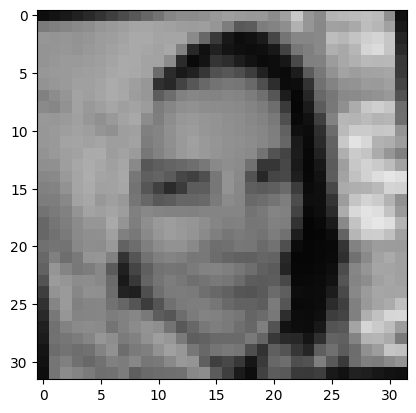

In [99]:
image, key_points = dataset['888']
plt.imshow(image)
plt.show()

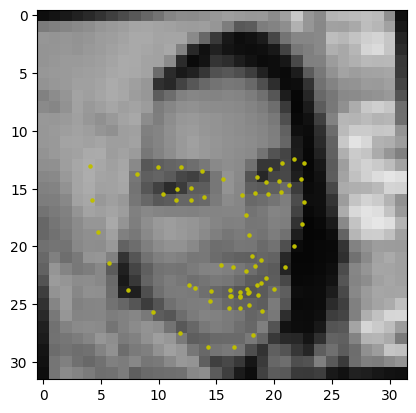

In [100]:
plt.imshow(image)
plt.scatter(key_points[:, 0], key_points[:, 1], marker='o', c='y', s=5)
plt.show()